In [408]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Utils

In [409]:
def read_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError("Check the img_path variable")
    return img

def show_img(img, title="Original Image", axis=False):
    plt.title(title)
    if not axis:
        plt.axis('off')
    plt.imshow(img, cmap='gray')

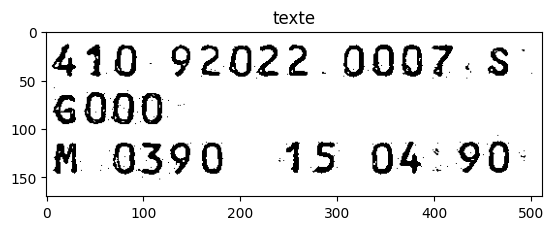

In [410]:
img_path = "img/texte.bmp"
img = read_img(img_path)

show_img(img, title="texte", axis=True)

# Profile of a Gray level image

In [411]:
def profile(img, offset, axis='H'):
    assert axis == "H" or axis == "V", "axis must be either 'H' or 'V'"
    assert offset >= 0, "The offset must be positive"
    if axis == "H":
        assert offset < img.shape[0], "the offset of a horizental profile\
            can't be greater than the number of rows of the image"
        
        return img[offset, :]
    else:
        assert offset < img.shape[1], "the offset of a vertical profile\
            can't be greater than the number of columns of the image"
        
        return img[:, offset]

def plot_profile(img, offset, axis='H'):
    profile_ = profile(img, offset, axis)
    plt.figure()
    axis_name = "Horizental" if axis=="H" else "Vertical"
    plt.title(axis_name + f" Profile at {offset}")
    plt.ylabel("NdG")
    plt.plot(range(len(profile_)), profile_)

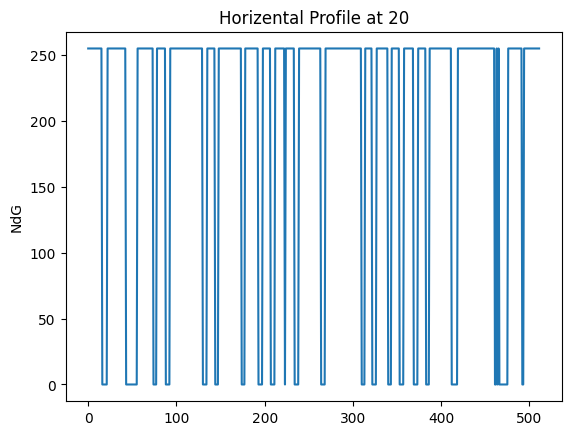

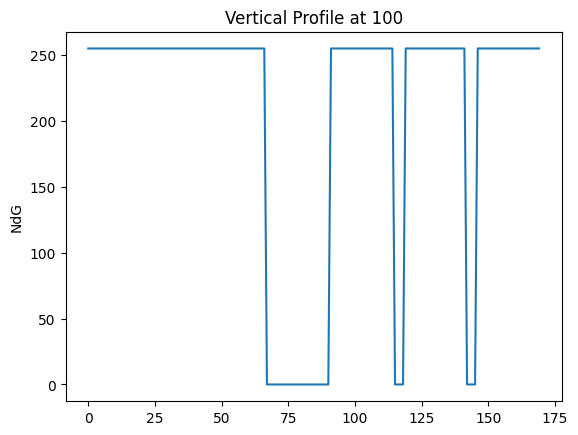

In [412]:
plot_profile(img, 20)
plot_profile(img, 100, "V")

# Projection of a Gray level image

In [413]:
def projection(img, offset, axis='H'):
    return profile(img, offset, axis).sum()

def plot_projection(img, axis='H'):
    axe = 0 if axis=='H' else 1
    proj = [projection(img, offset, axis) \
            for offset in range(img.shape[axe])]
    
    plt.figure()
    axis_name = "Horizental" if axis=="H" else "Vertical"
    plt.title(axis_name + f" Projection")
    plt.ylabel("NdG")
    plt.plot(range(len(proj)), proj)

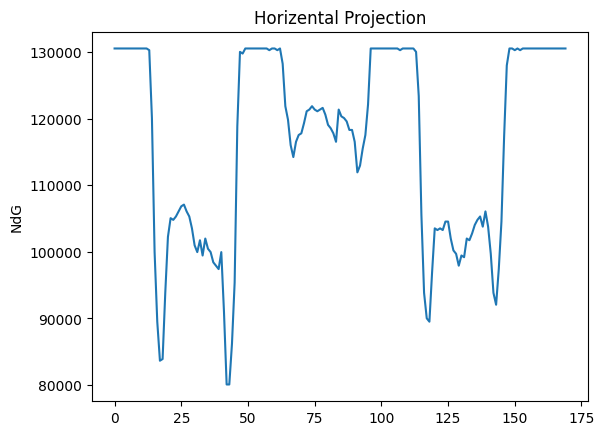

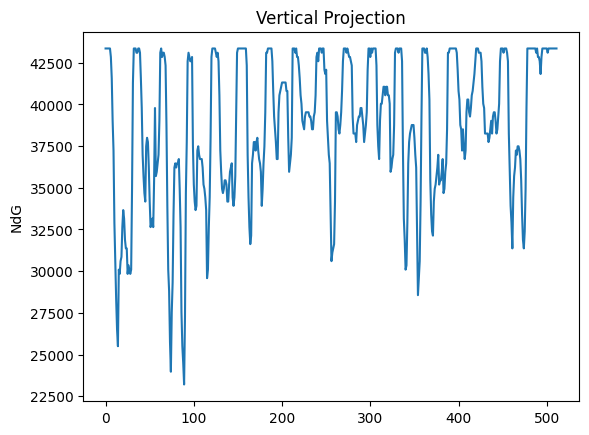

In [414]:
plot_projection(img)
plot_projection(img, "V")

# Histogram

In [415]:
def histogram(img, normal=False, cumulative=False):
    img_int = img.astype(int)
    intensities, counts_ = np.unique(img_int, return_counts=True)
    counts = np.zeros(256)
    counts[intensities] = counts_
    if normal:
        counts = counts/img_int.size

    if cumulative:
        counts = np.cumsum(counts)   

    return intensities, counts     

def plot_hist(img, normal=False, cumulative=False, title="Histogram"):
    _, counts = histogram(img, normal, cumulative)
    plt.title(title), plt.xlabel("NdG"), plt.ylabel("#NdG")
    plt.bar(range(256), counts)    

In [416]:
def hist_stretch(img, bornes='minmax'):
    assert bornes == "minmax" or bornes == "percentilles", \
        "axis must be either 'minmax' or 'percentilles'"
    
    if bornes == 'minmax':
        inf = img.min()
        sup = img.max()
    else:
        inf = np.percentile(img, 10)
        sup = np.percentile(img, 90)

    # Transform the Look up Table    
    LuT = np.arange(256)
    LuT = np.clip((LuT - inf)/(sup - inf)*255, 0, 255)  
      
    return LuT[img.astype(int)]

In [417]:
def hist_equal(img):
    _, counts = histogram(img, normal=True, cumulative=True)
    return np.round(counts[img]*255)

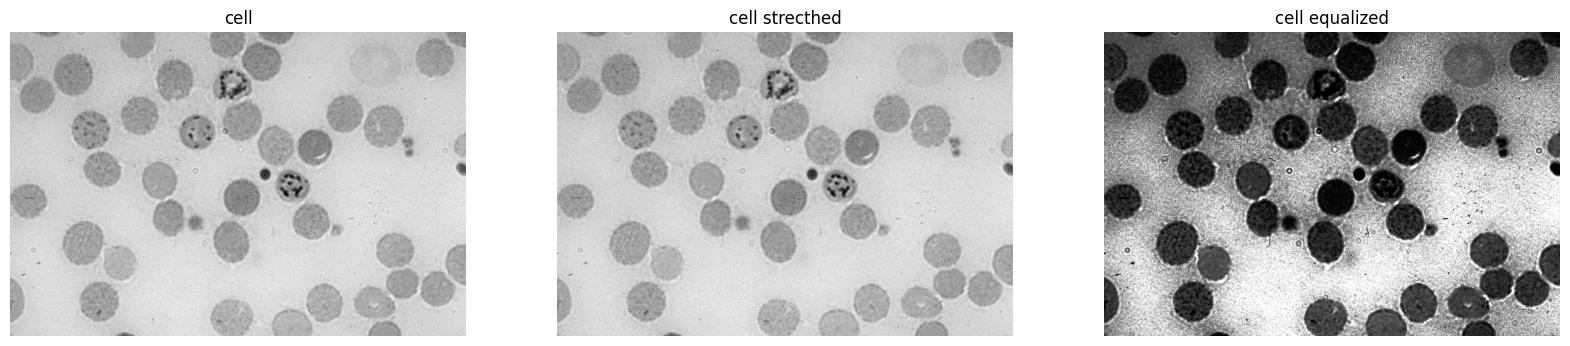

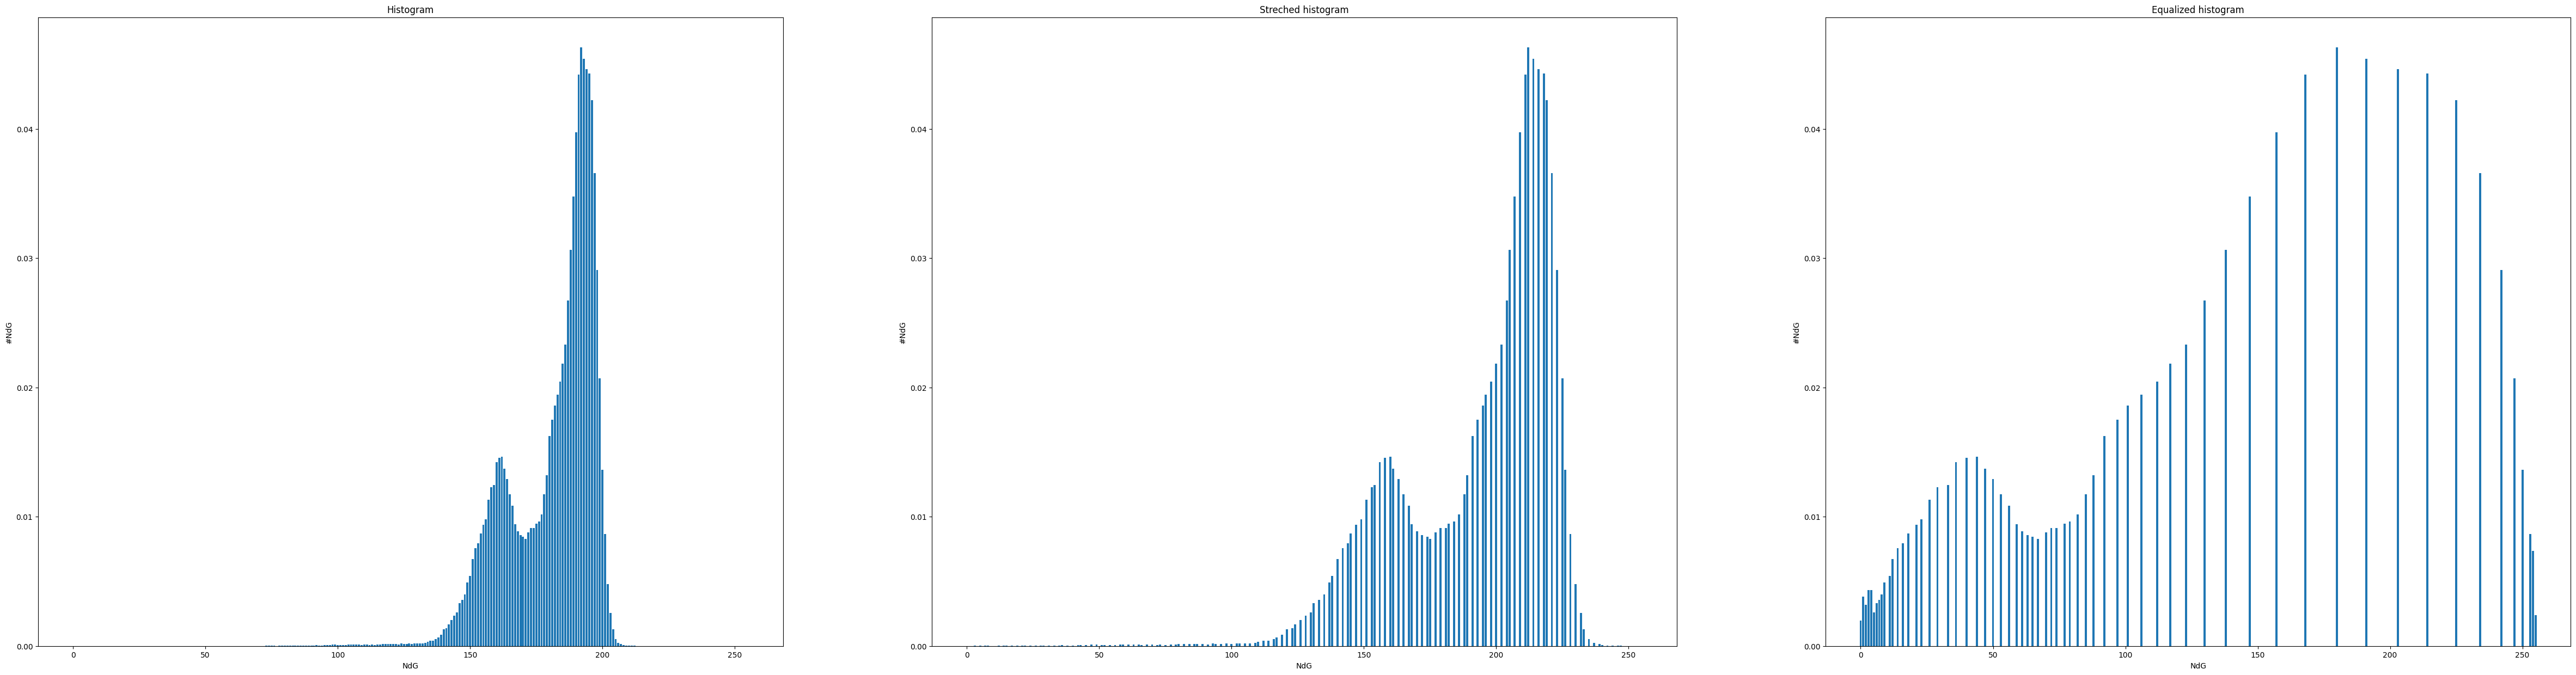

In [418]:
img_path = "img/cell.jpg"

# Loading Images
img = read_img(img_path)
str_img = hist_stretch(img)
equ_img = hist_equal(img)

# Plot the images
plt.figure(figsize=[20, 60])
plt.subplot(131), show_img(img, "cell")
plt.subplot(132), show_img(str_img, "cell strecthed")
plt.subplot(133), show_img(equ_img, "cell equalized")
plt.show()

# Plot the histograms
plt.figure(figsize=[60, 15])
plt.subplot(131), plot_hist(img, normal=True)
plt.subplot(132), plot_hist(str_img, normal=True, title="Streched histogram")
plt.subplot(133), plot_hist(equ_img, normal=True, title="Equalized histogram")
plt.show()

# Gamma Correction

In [419]:
def gamma_corr(img, gamma):
    return img**(1/gamma)

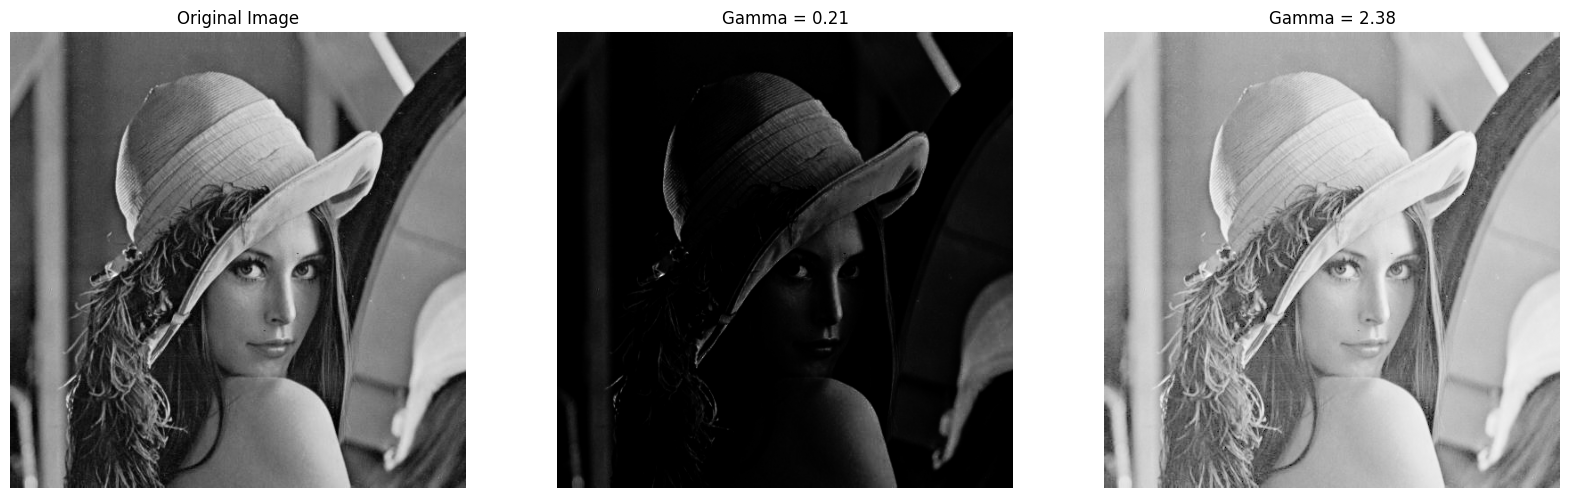

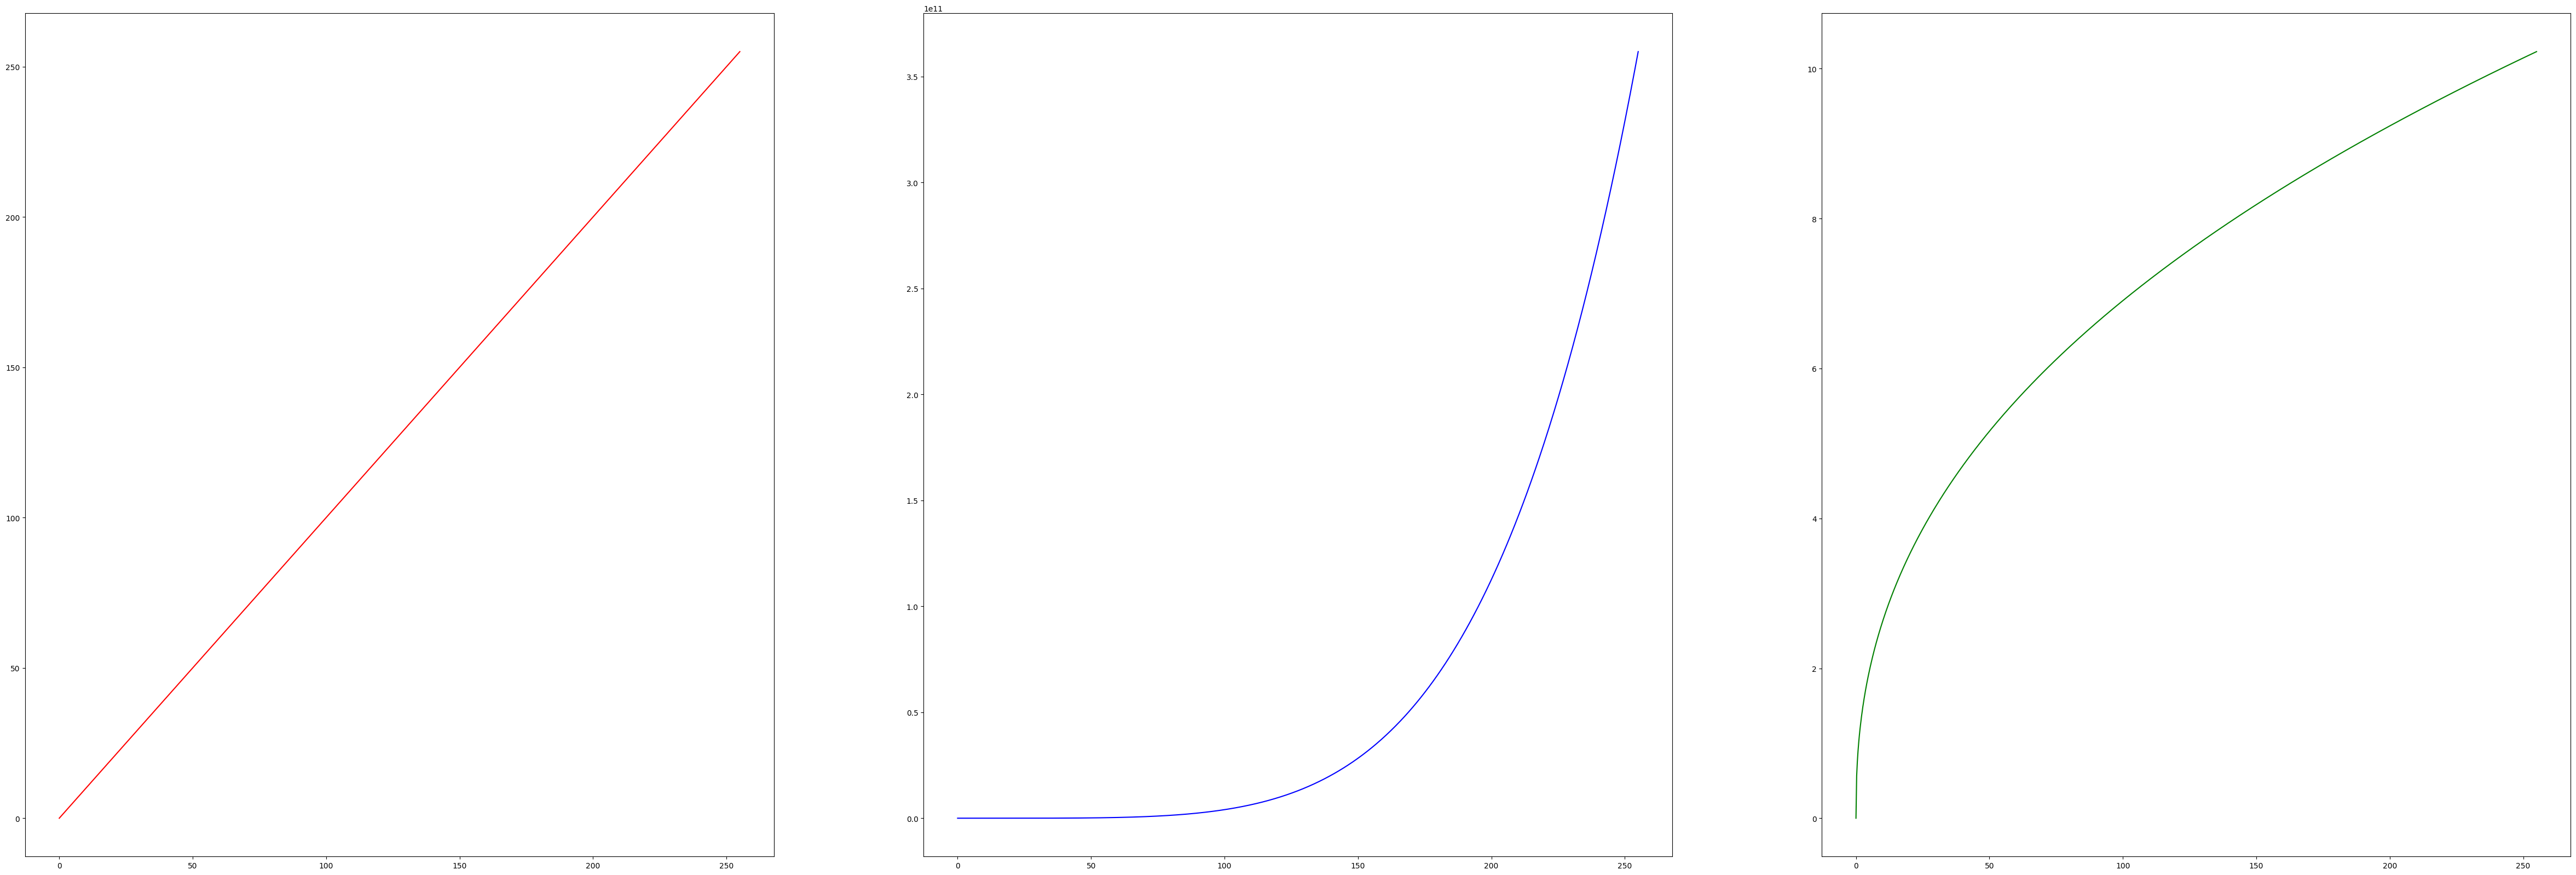

In [420]:
img_path = "img/lena1.jpg"
img = read_img(img_path)

gamma_1 = np.random.rand() 
if gamma_1 == 0:
    gamma_1 =0.4
gamma_2 = 1 + 5*np.random.rand()

# Plot the images
plt.figure(figsize=[20, 60])
plt.subplot(131), show_img(img)
plt.subplot(132), show_img(gamma_corr(img, gamma_1), f"Gamma = {gamma_1:.2f}")
plt.subplot(133), show_img(gamma_corr(img, gamma_2), f"Gamma = {gamma_2:.2f}")
plt.show()

# Plot the Gamma correction
x = np.linspace(0, 255, 1000)
plt.figure(figsize=[60, 20])
plt.subplot(131), plt.plot(x, x, 'r')
plt.subplot(132), plt.plot(x, x**(1/gamma_1), 'b')
plt.subplot(133), plt.plot(x, x**(1/gamma_2), 'g')
plt.show()

## Remarks:
    - The red curve corresond to gamma = 1 and it is the identity function
    - The blue curve corresponding to the 0 < gamma_1 < 1 is a convex function and it is under the red curve, that's why the images to which we've applied such a gamma value are darker (smaller intensity)
    - The green curve corresponding to the gamma_2 > 1 is a concave function and it is above the red curve, that's why the images to which we've applied such a gamma value are clearer (bigger intensity)

# Binarization

In [513]:
def otsu(img, trace=False):
    n = 256
    intra_std = np.ones(n)*np.inf
    for i in range(n):
        class_0 = img < i
        class_1 = img >= i

        std_0 = img[class_0].std() if np.any(class_0) else 0
        std_1 = img[class_1].std() if np.any(class_1) else 0

        w1, w2 = class_0.sum()/img.size, class_1.sum()/img.size  
        if trace:
            print(f"Threshold : {i}")
            print(f"std_0 : {std_0:.2f} | std_1 : {std_1:.2f}") 
            print(f"w_1 : {w1:.2f} | w_2 : {w2:.2f}") 
            print(f"intra_std : {w1*std_0 + w2*std_1:.2f}")
            print("_________")
        intra_std[i] = w1*std_0 + w2*std_1

    return intra_std.argmin()

In [512]:
#print(otsu(img, trace=True))

## Global Thresholding

In [ ]:
def thresh(img, threshold=None):
    assert 0 <= threshold <= 255\
        , "threshold must be in range(0,256)"
    
    if threshold is None:
        threshold = otsu(img)

    binary_img = np.zeros(shape=img.shape, dtype=np.uint8)    
    binary_img[img >= threshold] = 255
    return binary_img, threshold

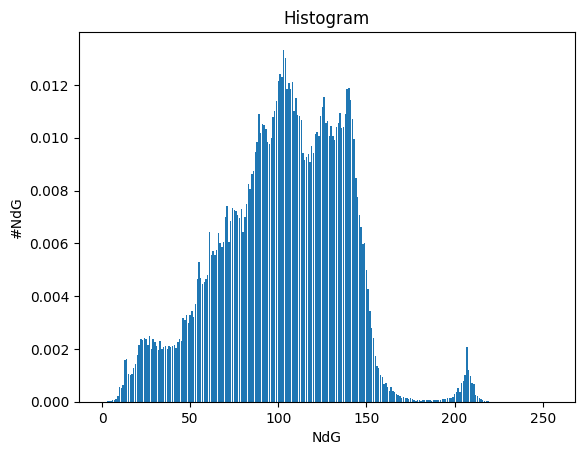

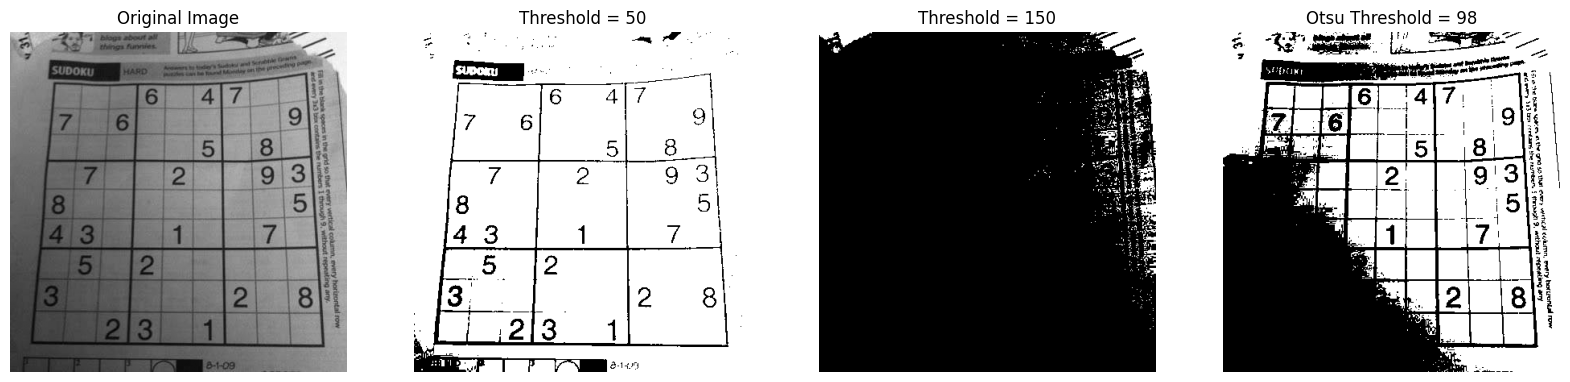

In [515]:
img_path = "img/sudoko.jpg"
img = read_img(img_path)
thresh_1 = 50
thresh_2 = 150

# lot the histogram
plot_hist(img, True)

# Plot the images
plt.figure(figsize=[20, 80])
plt.subplot(141), show_img(img)
plt.subplot(142), show_img(thresh(img, thresh_1)[0], f"Threshold = {thresh_1}")
plt.subplot(143), show_img(thresh(img, thresh_2)[0], f"Threshold = {thresh_2}")
binary_img, otsu_ = thresh(img)
plt.subplot(144), show_img(binary_img, f"Otsu Threshold = {otsu_}")
plt.show()

## Local Thresholding

In [516]:
def subimages(img, n):
    r = int(np.floor(img.shape[0]/n))
    c = int(np.floor(img.shape[1]/n))
    subimages_ = [] 
    for i in range(n):
        for j in range(n):
            subimages_.append(img[r*i:r*(i+1), c*j:c*(j+1)])
    return subimages_    

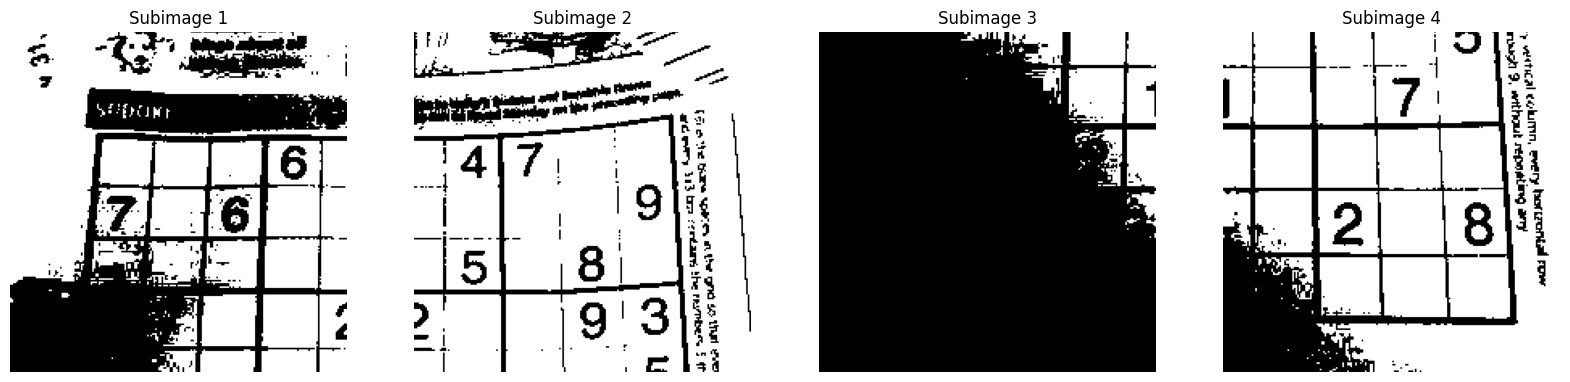

In [518]:
img_path = "img/sudoko.jpg"
img = read_img(img_path)

s = subimages(img, 2)

# Plot the images
plt.figure(figsize=[20, 80])
img_, thresh_ = thresh(s[0])
plt.subplot(141), show_img(img_, f"Subimage 1")
img_, thresh_ = thresh(s[1])
plt.subplot(142), show_img(img_, f"Subimage 2")
img_, thresh_ = thresh(s[2])
plt.subplot(143), show_img(img_, f"Subimage 3")
img_, thresh_ = thresh(s[3])
plt.subplot(144), show_img(img_, f"Subimage 4")
plt.show()

In [506]:
def assemble_imgs(imgs, n):
    unit_r, unit_c = imgs[0].shape
    image = np.zeros(shape=(unit_r*n, unit_c*n), dtype=np.uint8)
    for i in range(n):
        for j in range(n):
            image[i*unit_r : (i+1)*unit_r, j*unit_c : (j+1)*unit_c] = imgs[i*n+j]
    return image        

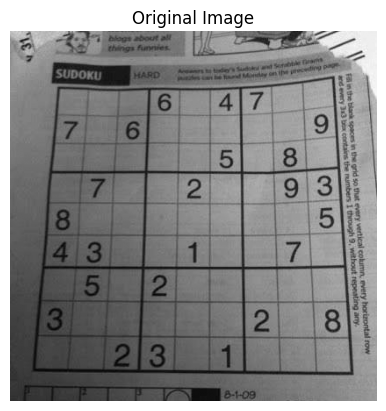

In [507]:
#np.random.shuffle(s)
show_img(assemble_imgs(s, 2))

In [508]:
def local_thresh(img, n):
    thresholds = []
    thresh_parts = []
    for img_ in subimages(img, n):
        img_, thresh_ = thresh(img_)
        thresh_parts.append(img_)
        thresholds.append(int(thresh_))
        #plt.figure(), show_img(img_), plt.show()

    return assemble_imgs(thresh_parts, n), thresholds     

[98, 98, 98, 98, 98, 98, 98, 98, 98]


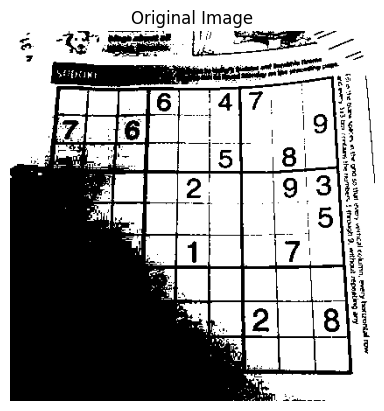

In [509]:
lt = local_thresh(img, 3)
print(lt[1])
show_img(lt[0])